In [16]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import layers

In [32]:
import matplotlib.pylab as plt
import numpy as np
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import urllib3
urllib3_logger = logging.getLogger("urllib3")
urllib3_logger.setLevel(logging.ERROR)


import random

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [33]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

In [34]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
    num_training_examples+=1

for example in validation_set:
    num_validation_examples+=1

print("Total no.of classes: {}".format(num_classes))
print("Total no.of training images: {}".format(num_training_examples))
print("Total no.of validation images: ", num_validation_examples)

Total no.of classes: 5
Total no.of training images: 2569
Total no.of validation images:  1101


In [35]:
for i, example in enumerate(training_set.take(5)):
    print("Image: {} shape: {} label: {}".format(i+1, example[0].shape, example[1]))

Image: 1 shape: (333, 500, 3) label: 2
Image: 2 shape: (212, 320, 3) label: 3
Image: 3 shape: (240, 320, 3) label: 3
Image: 4 shape: (240, 320, 3) label: 4
Image: 5 shape: (317, 500, 3) label: 3


In [36]:
img_res = 224

def format_image(image, label):
    image = tf.image.resize(image, (img_res, img_res))/255.0
    return image, label

batch = 32

train_batches = training_set.shuffle(num_training_examples //4 ).map(format_image).batch(batch).prefetch(1)

validation_batches = validation_set.map(format_image).batch(batch).prefetch(1)

mobilenet

In [37]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(url,
                                   input_shape = (img_res, img_res, 3))

In [38]:
feature_extractor.trainable = False

In [39]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [40]:
model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [41]:
epochs = 6

history = model.fit(train_batches,
                    epochs = epochs,
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 48s 551ms/step - loss: 0.7119 - accuracy: 0.7419 - val_loss: 0.4318 - val_accuracy: 0.8610
Epoch 2/6
81/81 [==============================] - 44s 540ms/step - loss: 0.3777 - accuracy: 0.8719 - val_loss: 0.3547 - val_accuracy: 0.8883
Epoch 3/6
81/81 [==============================] - 46s 566ms/step - loss: 0.2953 - accuracy: 0.8984 - val_loss: 0.3286 - val_accuracy: 0.8928
Epoch 4/6
81/81 [==============================] - 42s 525ms/step - loss: 0.2485 - accuracy: 0.9260 - val_loss: 0.3048 - val_accuracy: 0.8937
Epoch 5/6
81/81 [==============================] - 42s 515ms/step - loss: 0.2151 - accuracy: 0.9350 - val_loss: 0.3046 - val_accuracy: 0.8946
Epoch 6/6
81/81 [==============================] - 40s 497ms/step - loss: 0.1869 - accuracy: 0.9475 - val_loss: 0.2890 - val_accuracy: 0.9010


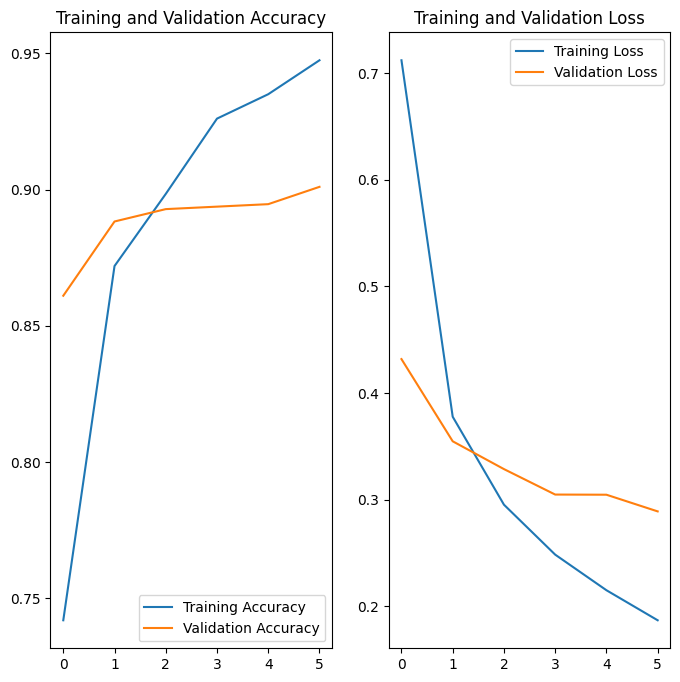

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [44]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 1s 662ms/step
['sunflowers' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses'
 'sunflowers' 'dandelion' 'tulips' 'sunflowers' 'roses' 'dandelion'
 'sunflowers' 'dandelion' 'sunflowers' 'roses' 'dandelion' 'tulips'
 'dandelion' 'tulips' 'sunflowers' 'roses' 'daisy' 'dandelion' 'tulips'
 'dandelion' 'dandelion' 'roses' 'tulips' 'tulips' 'daisy' 'daisy']


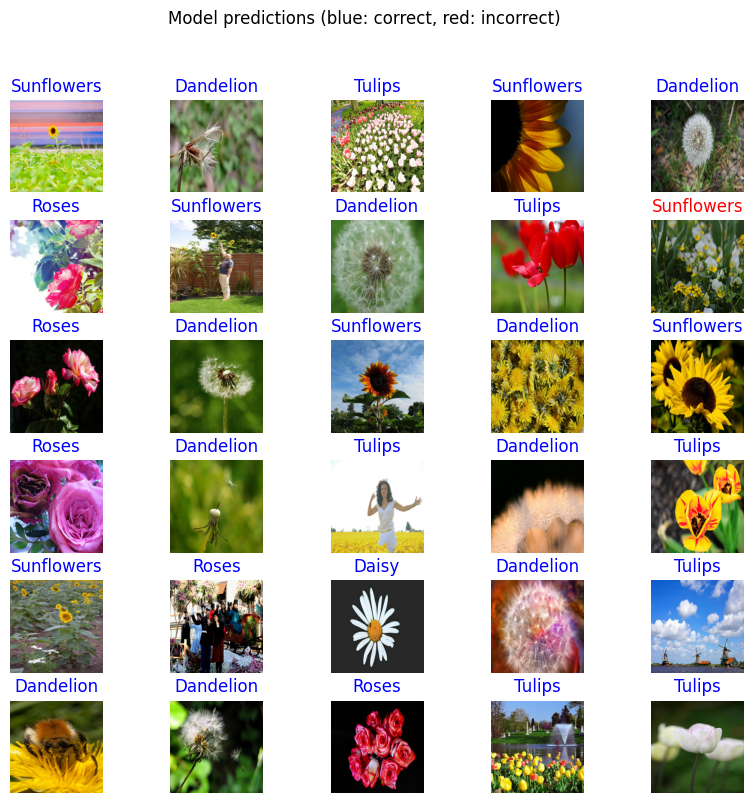

In [45]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")